In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Pupil Function

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

False True


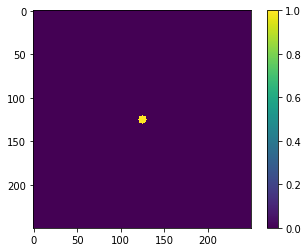

In [118]:
aperature_function = create_circular_mask(250, 250, radius=5)
# aperature_function = np.zeros((250,250))
# aperature_function[100:150, 120:130] = 1

print(np.min(aperature_function), np.max(aperature_function))
plt.imshow(aperature_function.astype(np.uint8))
plt.colorbar()

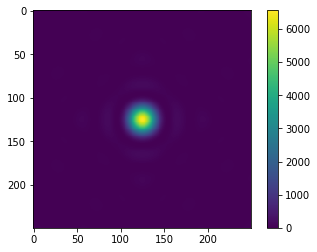

In [119]:
circle_fourier = np.abs(np.fft.fft2(aperature_function.astype(float))) ** 2
plt.imshow(np.fft.fftshift(circle_fourier))
plt.colorbar()

In [10]:
a = np.ones((2,2,2))
np.linalg.norm(a, ord=1, axis=-1)

array([[2., 2.],
       [2., 2.]])

In [34]:
origin = (200, 100)
depth = 300

def create_phase_matrix(height, width, origin, depth):
    x = np.arange(0, height, 1)
    y = np.arange(0, width,  1)
    
    xv, yv = np.meshgrid(x, y)
    zv = np.zeros_like(xv)
    
    grid = np.stack((xv, yv, zv), axis=-1)
    
    light_pos = np.array([*origin, depth])
    
    norms = np.linalg.norm(light_pos - grid, ord=2, axis=-1)
    assert norms.shape == (height, width)
    
    ratio = depth / norms
    
    phase = np.arcsin(ratio) # in interval [-pi/2, pi/2]
    return phase # in interval [0, pi]

#     return light_pos - grid
    

In [29]:
create_phase_matrix(4,4,(1,1),1)

array([[[ 1,  1,  3],
        [ 0,  1,  3],
        [-1,  1,  3],
        [-2,  1,  3]],

       [[ 1,  0,  3],
        [ 0,  0,  3],
        [-1,  0,  3],
        [-2,  0,  3]],

       [[ 1, -1,  3],
        [ 0, -1,  3],
        [-1, -1,  3],
        [-2, -1,  3]],

       [[ 1, -2,  3],
        [ 0, -2,  3],
        [-1, -2,  3],
        [-2, -2,  3]]])

In [122]:
phase = create_phase_matrix(250, 250,(62, 62),1)
phase = np.exp(phase * -1j)
pupil_func = aperature_function.astype(float) * phase


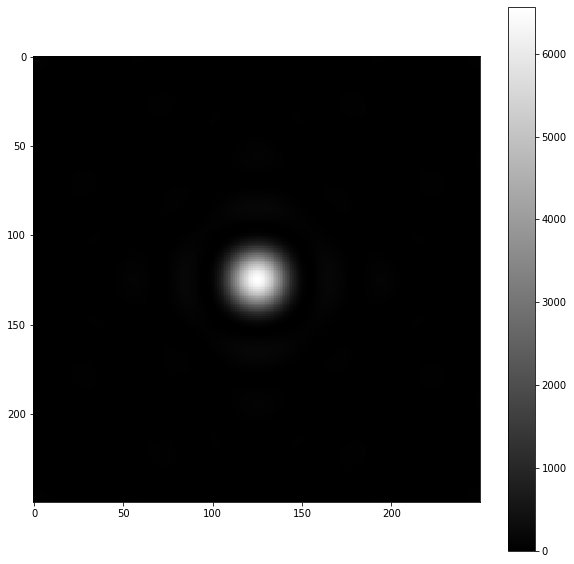

In [126]:
pupil_fourier = np.absolute(np.fft.fft2(pupil_func))**2
pupil_fourier = np.fft.fftshift(pupil_fourier)

plt.figure(figsize=(10,10))
plt.imshow(pupil_fourier, cmap='gray')
plt.colorbar()

## Spectral Response Function

In [55]:
from scipy.stats import norm

In [56]:
wavelengths = np.arange(380, 745, 5)

In [57]:
mu_R = np.random.uniform(620, 640, 1)
mu_G = np.random.uniform(540, 560, 1)
mu_B = np.random.uniform(460, 480, 1)

sigma_R = np.random.uniform(50, 60, 1)
sigma_G = np.random.uniform(50, 60, 1)
sigma_B = np.random.uniform(50, 60, 1)

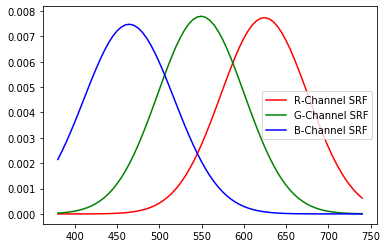

In [58]:
# Example SRF
plt.plot(wavelengths, norm.pdf(wavelengths, mu_R, sigma_R), color='r', label='R-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_G, sigma_G), color='g', label='G-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_B, sigma_B), color='b', label='B-Channel SRF')
plt.legend()

In [59]:
SRF_R = norm.pdf(wavelengths, mu_R, sigma_R)[None, :]
SRF_G = norm.pdf(wavelengths, mu_G, sigma_G)[None, :]
SRF_B = norm.pdf(wavelengths, mu_B, sigma_B)[None, :]

In [60]:
SRF = np.concatenate((SRF_R, SRF_G, SRF_B), axis=0)
SRF.shape

(3, 73)

## Combining

In [138]:
psf = np.repeat(np.expand_dims(pupil_fourier, axis=0), 73, axis=0)
psf = psf.reshape(73, -1)

In [139]:
psf.shape

(73, 62500)

In [148]:
psf_rgb = (SRF @ psf)

In [149]:
psf_rgb = psf_rgb.reshape(3, 250, 250)

In [150]:
psf_rgb = psf_rgb / np.max(psf_rgb)

In [132]:
psf_rgb

array([[[0.00739027, 0.00732822, 0.00714356, ..., 0.00684076,
         0.00714183, 0.00732734],
        [0.00732822, 0.00726657, 0.00708307, ..., 0.00678219,
         0.00708135, 0.00726569],
        [0.00714356, 0.00708307, 0.00690305, ..., 0.00660791,
         0.00690136, 0.00708221],
        ...,
        [0.00684076, 0.00678219, 0.00660791, ..., 0.00632224,
         0.00660627, 0.00678136],
        [0.00714183, 0.00708135, 0.00690136, ..., 0.00660627,
         0.00689967, 0.00708049],
        [0.00732734, 0.00726569, 0.00708221, ..., 0.00678136,
         0.00708049, 0.00726481]],

       [[0.00746837, 0.00740567, 0.00721906, ..., 0.00691306,
         0.00721731, 0.00740478],
        [0.00740567, 0.00734337, 0.00715793, ..., 0.00685387,
         0.00715619, 0.00734248],
        [0.00721906, 0.00715793, 0.00697601, ..., 0.00667775,
         0.0069743 , 0.00715706],
        ...,
        [0.00691306, 0.00685387, 0.00667775, ..., 0.00638906,
         0.00667609, 0.00685303],
        [0.0

In [142]:
psf_rgb

array([[[9.69293707, 9.61156036, 9.36936278, ..., 8.97221555,
         9.36708773, 9.61040083],
        [9.61156036, 9.53069494, 9.29002411, ..., 8.89539727,
         9.28776346, 9.52954271],
        [9.36936278, 9.29002411, 9.05391222, ..., 8.66681099,
         9.05169453, 9.28889367],
        ...,
        [8.97221555, 8.89539727, 8.66681099, ..., 8.29213174,
         8.66466422, 8.89430279],
        [9.36708773, 9.28776346, 9.05169453, ..., 8.66466422,
         9.04947724, 9.28663322],
        [9.61040083, 9.52954271, 9.28889367, ..., 8.89430279,
         9.28663322, 9.52839058]],

       [[9.79537898, 9.71314222, 9.46838492, ..., 9.06704036,
         9.46608583, 9.71197044],
        [9.71314222, 9.63142216, 9.38820775, ..., 8.9894102 ,
         9.3859232 , 9.63025775],
        [9.46838492, 9.38820775, 9.14960045, ..., 8.75840807,
         9.14735933, 9.38706536],
        ...,
        [9.06704036, 8.9894102 , 8.75840807, ..., 8.37976893,
         8.75623861, 8.98830416],
        [9.4

In [146]:
psf_rgb.sum(axis=0)

array([[28.78074912, 28.53912135, 27.81997628, ..., 26.64074707,
        27.81322111, 28.53567842],
       [28.53912135, 28.29901173, 27.58439999, ..., 26.4126544 ,
        27.57768755, 28.29559047],
       [27.81997628, 27.58439999, 26.88332485, ..., 25.73392471,
        26.87673997, 27.58104342],
       ...,
       [26.64074707, 26.4126544 , 25.73392471, ..., 24.62140849,
        25.7275504 , 26.40940463],
       [27.81322111, 27.57768755, 26.87673997, ..., 25.7275504 ,
        26.8701563 , 27.57433159],
       [28.53567842, 28.29559047, 27.58104342, ..., 26.40940463,
        27.57433159, 28.29216951]])

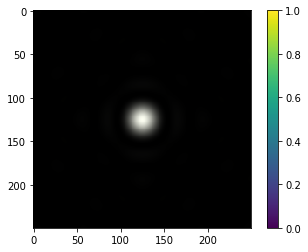

In [152]:
plt.imshow(np.transpose(psf_rgb, (1, 2, 0)))
plt.colorbar()